In [1]:
import warnings
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from scipy.cluster.hierarchy import dendrogram
from yellowbrick.cluster import KElbowVisualizer
from kneed import KneeLocator
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
with open('./mod_06_topic_12_nci_data.pkl', 'rb') as fl:
    data_dict = pickle.load(fl)

data = data_dict['data']
target = data_dict['labels']

data.shape

(64, 6830)

In [3]:
target['label'].value_counts().sort_index()

label
BREAST         7
CNS            5
COLON          7
K562A-repro    1
K562B-repro    1
LEUKEMIA       6
MCF7A-repro    1
MCF7D-repro    1
MELANOMA       8
NSCLC          9
OVARIAN        6
PROSTATE       2
RENAL          9
UNKNOWN        1
Name: count, dtype: int64

In [4]:
X = StandardScaler().fit_transform(data)

pca = PCA(random_state=42).fit(X)
pve = pca.explained_variance_ratio_

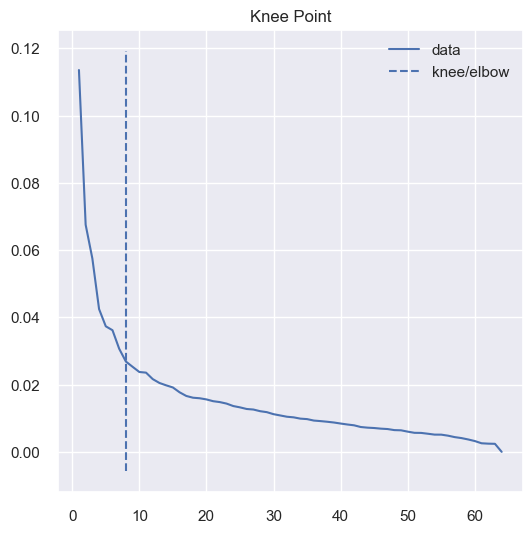

In [5]:
sns.set_theme()

kneedle = KneeLocator(
    x=range(1, len(pve) + 1),
    y=pve,
    curve='convex',
    direction='decreasing')

kneedle.plot_knee()

[Text(0.5, 0, 'number of components'),
 Text(0, 0.5, 'cumulative explained variance')]

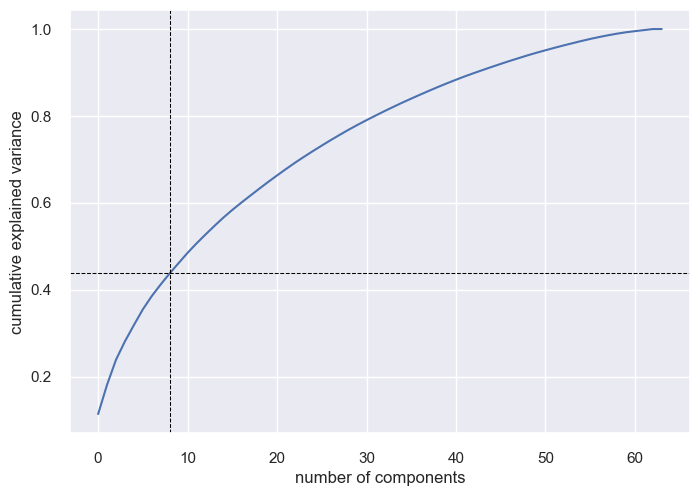

In [6]:
n_components = kneedle.elbow

ax = sns.lineplot(np.cumsum(pve))

ax.axvline(x=n_components,
           c='black',
           linestyle='--',
           linewidth=0.75)

ax.axhline(y=np.cumsum(pve)[n_components],
           c='black',
           linestyle='--',
           linewidth=0.75)

ax.set(xlabel='number of components',
       ylabel='cumulative explained variance')

In [7]:
n_components

8

In [8]:
X = pca.transform(X)[:, :n_components]

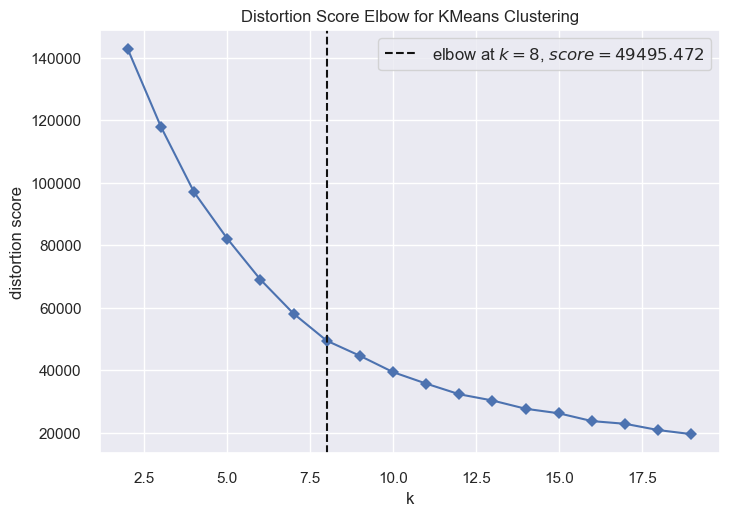

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [10]:
model_kmn = KMeans(random_state=42)

visualizer = KElbowVisualizer(
    model_kmn,
    k=(2, 20),
    timings=False)


with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    visualizer.fit(X)

visualizer.show()

In [11]:
def plot_dendrogram(model, **kwargs):

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)

In [12]:
model_agg = AgglomerativeClustering(
    distance_threshold=0,
    n_clusters=None)

model_agg = model_agg.fit(X)

Text(0.5, 0, 'Number of points in node (or index of point if no parenthesis)')

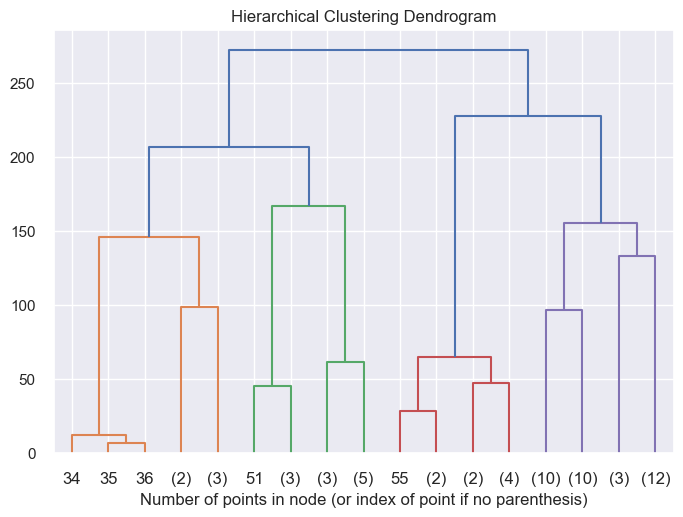

In [13]:
plot_dendrogram(model_agg, truncate_mode='level', p=3)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Number of points in node (or index of point if no parenthesis)')

In [14]:
k_best = 5 # visualizer.elbow_value_

with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    model_kmn = KMeans(n_clusters=k_best, random_state=42).fit(X)
    model_agg = AgglomerativeClustering(n_clusters=k_best).fit(X)

labels_kmn = pd.Series(model_kmn.labels_, name='k-means')
labels_agg = pd.Series(model_agg.labels_, name='h-clust')

In [15]:
pd.crosstab(labels_agg, labels_kmn)

k-means,0,1,2,3,4
h-clust,,,,,
0,0,0,35,0,0
1,8,0,0,0,0
2,0,9,0,0,0
3,0,0,0,0,8
4,0,0,0,4,0


In [16]:
pd.crosstab(target['label'], labels_kmn)

k-means,0,1,2,3,4
label,,,,,
BREAST,0,2,3,2,0
CNS,0,0,5,0,0
COLON,0,0,0,0,7
K562A-repro,1,0,0,0,0
K562B-repro,1,0,0,0,0
LEUKEMIA,6,0,0,0,0
MCF7A-repro,0,0,0,1,0
MCF7D-repro,0,0,0,1,0
MELANOMA,0,7,1,0,0


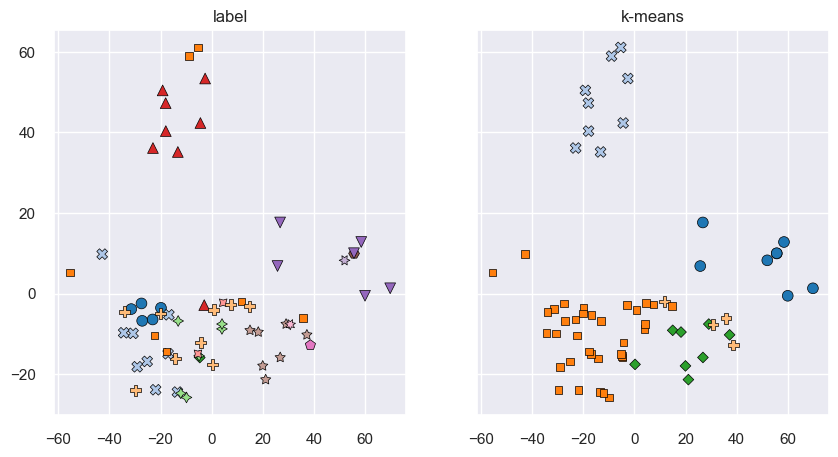

In [17]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5), sharey=True)

for i, s in enumerate([target['label'], labels_kmn]):
    ax = axes[i]

    sns.scatterplot(x=X[:, 0],
                    y=X[:, 1],
                    hue=s,
                    style=s,
                    edgecolor='black',
                    linewidth=0.5,
                    s=60,
                    palette='tab20',
                    legend=False,
                    ax=ax)

    ax.set(title=s.name)